In [2]:
# Unzip Dataset 
import gzip
import shutil

with gzip.open('output/output.vcf.gz', 'rb') as f_in:
    with open('output/output.vcf', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
import io
import os
import pandas as pd

def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

vcf_dataframe = read_vcf('output/output.vcf')

print(vcf_dataframe.head())

   CHROM       POS ID REF  ALT  QUAL FILTER INFO              FORMAT  \
0  chr20   9999996  .   A  ACT  39.7   PASS    .  GT:GQ:DP:AD:VAF:PL   
1  chr20  10000117  .   C    T  26.1   PASS    .  GT:GQ:DP:AD:VAF:PL   
2  chr20  10000211  .   C    T  39.2   PASS    .  GT:GQ:DP:AD:VAF:PL   
3  chr20  10000439  .   T    G  29.9   PASS    .  GT:GQ:DP:AD:VAF:PL   
4  chr20  10000598  .   T    A  45.2   PASS    .  GT:GQ:DP:AD:VAF:PL   

                            NA12878  
0          1/1:38:44:0,44:1:39,43,0  
1  0/1:26:55:25,30:0.545455:26,0,41  
2  0/1:39:59:30,29:0.491525:39,0,54  
3          1/1:30:72:0,72:1:29,42,0  
4          1/1:44:46:0,46:1:45,51,0  


In [4]:
# Read in Hypertension journal data

hypertension_dataframe = pd.read_csv('hypertension_markers.csv')
hypertension_dataframe['chr position'] = pd.to_numeric(list(map(
    lambda a: a.replace(',', ''), 
    hypertension_dataframe['chr position'])))

print(hypertension_dataframe.head(100))

          locus name          snp  chr id  chr position coded allele  \
0             2q36.3    rs2972146       2     226235982            T   
1             7q32.1    rs4728142       7     128933913            A   
2            ABHD17C   rs35199222      15      80720696            A   
3            ABHD17C   rs11634851      15      80736624            G   
4      ABLIM3-SH3TC2    rs9687065       5     149011577            A   
5                ACE       rs4308      17      63482264            A   
6              ACOX1    rs2467099      17      75952964            T   
7    ADAMTS7-MORF4L1   rs62012628      15      78777658            T   
8    ADAMTS7-MORF4L1   rs62011052      15      79156983            C   
9            ADAMTS8   rs11222084      11     130403335            T   
10           ADAMTS9     rs918466       3      64724577            A   
11             ADCY3   rs55701159       2      24916727            T   
12               ADM     rs360157      11       9732674         

In [7]:
# Augment with hypertension impace
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def hypertension_factor(row):
    result = hypertension_dataframe.loc[hypertension_dataframe['chr position'] == row['POS']]
    if len(result > 0):
        return result['effect size of BT'] * row['QUAL']
    else:
        return 0

SCALE_FAC = 15
vcf_dataframe['hypertension_impact'] = vcf_dataframe.apply(hypertension_factor, axis=1)

In [25]:
# Basic statistics about the VCF Data 
from IPython.display import IFrame
IFrame('output/output.visual_report.html', width=800, height=1000)

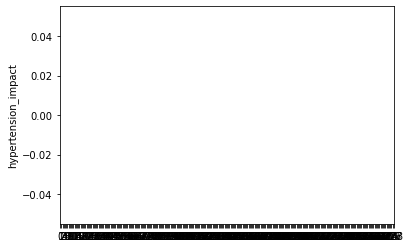

In [28]:
# Basic Heatmap to visualize what has bearing on hypertension for a given patient 
sns.barplot(x=vcf_dataframe.index, y=vcf_dataframe['hypertension_impact'], palette="deep")

## Some Notes

Unfortunately, on the the reduced dataset the approach of using the position to determine which of the SNPS based on their position results in none of the provided variations showing up in the journal results. More extensive analysis on the full genomic sequence would be needed to truly invalidate this approach, however that requires more time than is available during this hackathon. 